# Build a model to classify topics for Telegram channels

**Pre-req**
1. Download csv from gdrive with channels and save to ``data/external/telegram_channels.csv``
2. Run ``python -m src.train.download`` to get posts and meta-data

**Steps**
1. Load data:
    - posts from channels
    - channel titles and descriptions
    - channel topics
2. Build a training dataset:
    1. Merge
    2. Select inputs
    3. Split into train/val
3. Build models:
    1. Embed text
    2. Train a classifier
    3. Select best
4. Evaluate on test data and save best

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt

# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm, notebook_tqdm

from torchtext import data
import re


/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# custom path
os.chdir('..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'


## Data configs

In [41]:
THESTACK = "./data/raw/thestack_v2/"
TEST = "./data/raw/tg-r1-test/"
TEST_OTHER = "./data/raw/ml2023-r1-dataset/"

TRAIN_OTHER_RATIO = 0.2
TEST_OTHER_RATIO = 1.0

LINES = (5, 13)
MAX_CHARS = 4096

FILTER_CODE_OTHER = True

In [42]:
SAVE_TRAIN = "./data/processed/tglang_train.csv"
SAVE_TEST = "./data/processed/tglang_test.csv"
SAVE_SPE_DATA = "./data/processed/tglang_spe.txt"

## Load data

In [67]:
def extract_text_blocks(file, augment=True):
    text = file.read_text().strip()[:MAX_CHARS]
    lines = re.split("\n+", text)
    n = 0
    blocks = []
    while n < len(lines):
        if augment:
            n_lines = random.randint(LINES[0], LINES[1])
        else:
            n_lines = len(lines)

        blocks.append(lines[n: n+n_lines])
        
        n += n_lines

    return blocks


def load_dataset(files, blocks=True):
    data = []
    for f in files:
        try:
            blocks = extract_text_blocks(f, augment=blocks)
            for block in blocks:
                n_lines = len(block)
                block = "\n".join(block)
                data.append((block, f.parent.name.strip(), len(block), n_lines, str(f)))
        except UnicodeDecodeError as e:
            print(f"Unable to read {f!r}", e)

    data = pd.DataFrame(data, columns=["content", "lang", "num_chars", "num_lines", "file"])
    return data


def get_files(folder, filter_other):
    files = Path(folder).rglob("*.*")

    files = filter(lambda x: bool(x.suffix), files)
    files = filter(lambda x: x.parent.name.strip() in LANG_ENUM, files)
    if filter_other:
        files = filter(lambda x: x.parent.name.strip() != LANG_ENUM[0], files)

    return list(files)

### Lang enum

In [44]:
LANG_ENUM = Path("./src/tglang/langs_enum_r2.txt").read_text().split()
LANG_ENUM = [l.strip() for l in LANG_ENUM]

len(LANG_ENUM)

29

### get train files

In [68]:
files = get_files(THESTACK, FILTER_CODE_OTHER)

len(files)

3673

### Load content

In [69]:
thestack = load_dataset(files)
thestack.sample(5)

,content,lang,num_chars,num_lines,file
14884,"<Compile Include=""Program.cs"" />\n <Com...",TGLANG_LANGUAGE_XML,347,8,data/raw/thestack_v2/ TGLANG_LANGUAGE_XML/37.txt
5242,// SPDX-License-Identifier: MIT\npragma solidi...,TGLANG_LANGUAGE_SOLIDITY,194,7,data/raw/thestack_v2/ TGLANG_LANGUAGE_SOLIDIT...
9895,"count: newCount,\n total_price: new...",TGLANG_LANGUAGE_JAVASCRIPT,233,9,data/raw/thestack_v2/TGLANG_LANGUAGE_JAVASCRIP...
21707,"#include ""components/metrics/metrics_service.h...",TGLANG_LANGUAGE_OBJECTIVE_C,283,6,data/raw/thestack_v2/ TGLANG_LANGUAGE_OBJECTI...
20943,/// Swift makes it as easy to create a new set...,TGLANG_LANGUAGE_SWIFT,348,8,data/raw/thestack_v2/TGLANG_LANGUAGE_SWIFT/Set...


In [70]:
thestack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26857 entries, 0 to 26856
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    26857 non-null  object
 1   lang       26857 non-null  object
 2   num_chars  26857 non-null  int64 
 3   num_lines  26857 non-null  int64 
 4   file       26857 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.0+ MB


#### Missing languages

In [71]:
diff_langs = set(LANG_ENUM).difference(thestack["lang"].unique())

print("Number of languages missing", len(diff_langs))

Number of languages missing 1


In [72]:
pprint(diff_langs)


{'TGLANG_LANGUAGE_OTHER'}


#### Filter Empty

In [74]:
empty = thestack.loc[(thestack["content"] == "") | (thestack["num_chars"] == 0)]

empty.shape


(4, 5)

In [75]:
thestack = thestack.loc[(thestack["content"] != "") & (thestack["num_chars"] > 2)]

thestack.shape

(26721, 5)

### EDA

In [76]:
from src.train.plot_utils import barplots

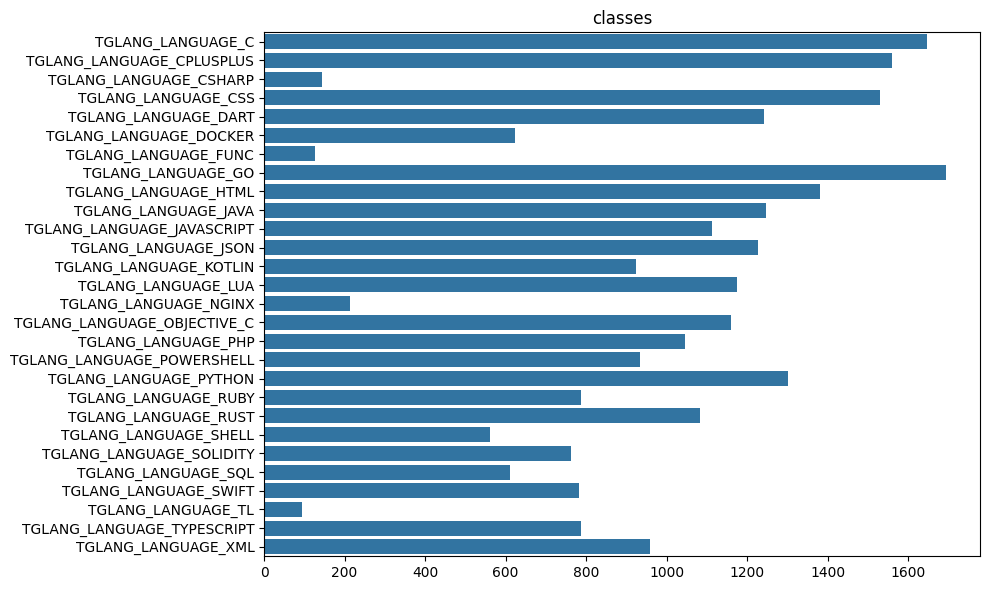

In [77]:
barplots({
    'classes': thestack['lang']
}, 1, 1, horizontal=True, fig_dims=(10, 6))

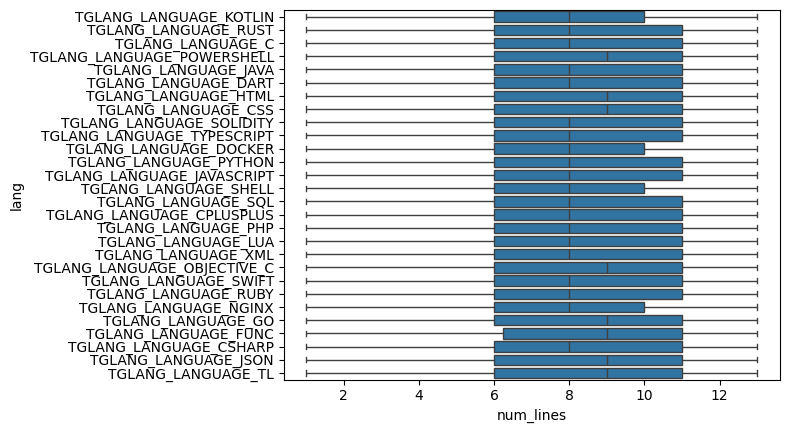

In [78]:
sns.boxplot(x=thestack["num_lines"], y=thestack["lang"]);

### Test set

In [79]:
test_files = get_files(TEST, FILTER_CODE_OTHER)

len(test_files)

417

In [80]:
test_set = load_dataset(test_files, blocks=False)

test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    875 non-null    object
 1   lang       875 non-null    object
 2   num_chars  875 non-null    int64 
 3   num_lines  875 non-null    int64 
 4   file       875 non-null    object
dtypes: int64(2), object(3)
memory usage: 34.3+ KB


#### Test stats

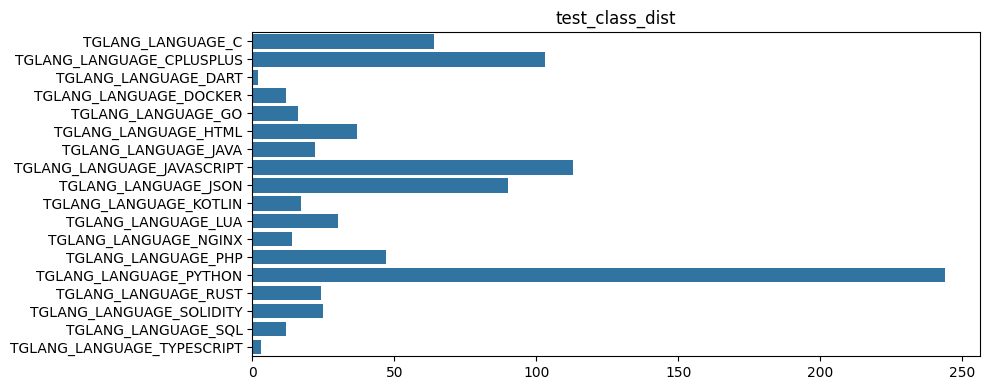

In [81]:
barplots({"test_class_dist": test_set["lang"]}, n_col=1, n_row=1, fig_dims=(10,4))

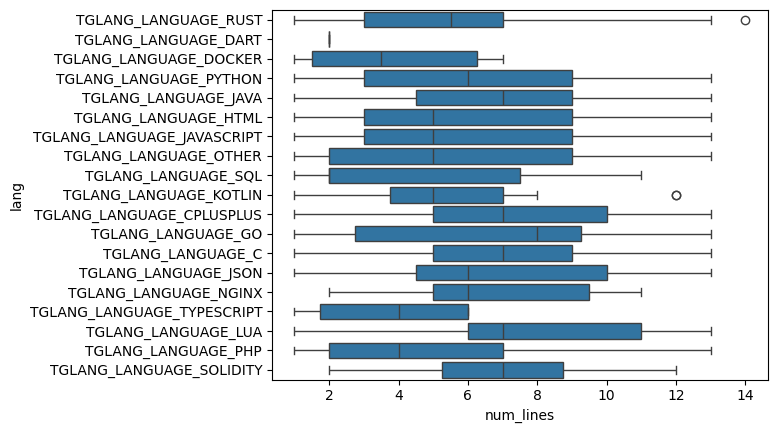

In [20]:
sns.boxplot(y=test_set["lang"], x=test_set["num_lines"]);

#### Add other class

In [82]:
test_other_files = list(Path(TEST_OTHER).rglob("*OTHER.txt"))
test_other_num = int(test_set.shape[0] * TEST_OTHER_RATIO)
test_other_selected = random.choices(test_other_files, k=test_other_num)

test_other = load_dataset(test_other_selected, blocks=False)
test_other["lang"] = "TGLANG_LANGUAGE_OTHER"

test_set = pd.concat([test_set,test_other])

In [83]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1948 entries, 0 to 1072
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    1948 non-null   object
 1   lang       1948 non-null   object
 2   num_chars  1948 non-null   int64 
 3   num_lines  1948 non-null   int64 
 4   file       1948 non-null   object
dtypes: int64(2), object(3)
memory usage: 91.3+ KB


In [84]:
test_set["lang"].value_counts(True)

lang
TGLANG_LANGUAGE_OTHER         0.550821
TGLANG_LANGUAGE_PYTHON        0.125257
TGLANG_LANGUAGE_JAVASCRIPT    0.058008
TGLANG_LANGUAGE_CPLUSPLUS     0.052875
TGLANG_LANGUAGE_JSON          0.046201
TGLANG_LANGUAGE_C             0.032854
TGLANG_LANGUAGE_PHP           0.024127
TGLANG_LANGUAGE_HTML          0.018994
TGLANG_LANGUAGE_LUA           0.015400
TGLANG_LANGUAGE_SOLIDITY      0.012834
TGLANG_LANGUAGE_RUST          0.012320
TGLANG_LANGUAGE_JAVA          0.011294
TGLANG_LANGUAGE_KOTLIN        0.008727
TGLANG_LANGUAGE_GO            0.008214
TGLANG_LANGUAGE_NGINX         0.007187
TGLANG_LANGUAGE_DOCKER        0.006160
TGLANG_LANGUAGE_SQL           0.006160
TGLANG_LANGUAGE_TYPESCRIPT    0.001540
TGLANG_LANGUAGE_DART          0.001027
Name: proportion, dtype: float64

#### Add other to train

In [85]:
train_other_num = int(thestack.shape[0] * TRAIN_OTHER_RATIO)
train_other_selected = random.choices(test_other_files, k=train_other_num)
train_other = load_dataset(train_other_selected, blocks=True)
train_other["lang"] = "TGLANG_LANGUAGE_OTHER"
thestack = pd.concat([thestack, train_other])

In [86]:
thestack.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33212 entries, 0 to 6490
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    33212 non-null  object
 1   lang       33212 non-null  object
 2   num_chars  33212 non-null  int64 
 3   num_lines  33212 non-null  int64 
 4   file       33212 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.5+ MB


In [87]:
thestack["lang"].value_counts(True)

lang
TGLANG_LANGUAGE_OTHER          0.195441
TGLANG_LANGUAGE_GO             0.051006
TGLANG_LANGUAGE_C              0.049621
TGLANG_LANGUAGE_CPLUSPLUS      0.047001
TGLANG_LANGUAGE_CSS            0.046068
TGLANG_LANGUAGE_HTML           0.041551
TGLANG_LANGUAGE_PYTHON         0.039173
TGLANG_LANGUAGE_JAVA           0.037577
TGLANG_LANGUAGE_DART           0.037426
TGLANG_LANGUAGE_JSON           0.036914
TGLANG_LANGUAGE_LUA            0.035349
TGLANG_LANGUAGE_OBJECTIVE_C    0.034957
TGLANG_LANGUAGE_JAVASCRIPT     0.033512
TGLANG_LANGUAGE_RUST           0.032639
TGLANG_LANGUAGE_PHP            0.031495
TGLANG_LANGUAGE_XML            0.028905
TGLANG_LANGUAGE_POWERSHELL     0.028152
TGLANG_LANGUAGE_KOTLIN         0.027791
TGLANG_LANGUAGE_RUBY           0.023726
TGLANG_LANGUAGE_TYPESCRIPT     0.023726
TGLANG_LANGUAGE_SWIFT          0.023546
TGLANG_LANGUAGE_SOLIDITY       0.022974
TGLANG_LANGUAGE_DOCKER         0.018788
TGLANG_LANGUAGE_SQL            0.018427
TGLANG_LANGUAGE_SHELL          0.01

## Save

### CSV

In [88]:
thestack.to_csv(SAVE_TRAIN, index=False)

test_set.to_csv(SAVE_TEST, index=False)

### Sentence-piece

In [89]:
write_file = Path(SAVE_SPE_DATA)
if write_file.exists():
    write_file.unlink()

with open(SAVE_SPE_DATA, mode="a") as f:
    for one in tqdm(files):
        f.write(one.read_text())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3673/3673 [00:00<00:00, 13817.05it/s]


In [90]:
!du -hs ./data/processed/*

 40M	./data/processed/tglang_spe.txt
520K	./data/processed/tglang_test.csv
 12M	./data/processed/tglang_train.csv
